# Two Layered Recommender Systems

Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als
import re
import time

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
# from src.recommenders import MainRecommender

In [2]:
data = pd.read_csv('./data/retail_train.csv')
item_features = pd.read_csv('./data/product.csv')
user_features = pd.read_csv('./data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)

val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

#week split --> train_lvl1: (1-85), val_lvl1: (86-91), train_lvl2: (86-91), val_lvl2: (92-95)

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [4]:
import pandas as pd
import numpy as np

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender  # нужен для одного трюка
from implicit.nearest_neighbours import bm25_weight, tfidf_weight


class MainRecommender:
    """Рекоммендации, которые можно получить из ALS
    Input
    -----
    user_item_matrix: pd.DataFrame
        Матрица взаимодействий user-item
    """

    def __init__(self, data, weighting=True):

        # Топ покупок каждого юзера
        self.top_purchases = data.groupby(['user_id', 'item_id'])['quantity'].count().reset_index()
        self.top_purchases.sort_values('quantity', ascending=False, inplace=True)
        self.top_purchases = self.top_purchases[self.top_purchases['item_id'] != 999999]

        # Топ покупок по всему датасету
        self.overall_top_purchases = data.groupby('item_id')['quantity'].count().reset_index()
        self.overall_top_purchases.sort_values('quantity', ascending=False, inplace=True)
        self.overall_top_purchases = self.overall_top_purchases[self.overall_top_purchases['item_id'] != 999999]
        self.overall_top_purchases = self.overall_top_purchases.item_id.tolist()

        self.user_item_matrix, self.matrix_index, self.matrix_columns = self._prepare_matrix(data)  # pd.DataFrame
        self.id_to_itemid, self.id_to_userid, \
            self.itemid_to_id, self.userid_to_id = self._prepare_dicts(self.user_item_matrix)

        if weighting:
            self.user_item_matrix = bm25_weight(self.user_item_matrix.T).T

        self.model = self.fit(self.user_item_matrix)
        self.own_recommender = self.fit_own_recommender(self.user_item_matrix)
        
        self.item_factors = self.model.item_factors
        self.user_factors = self.model.user_factors
        
        self.items_emb_df, self.users_emb_df = self.get_embeddings(self)
        
        
    @staticmethod
    def get_embeddings(self):
        items_emb = self.item_factors
        items_emb_df = pd.DataFrame(items_emb)
        items_emb_df.reset_index(inplace=True)
        items_emb_df['item_id'] = items_emb_df['index'].apply(lambda x: self.id_to_itemid[x])
        items_emb_df = items_emb_df.drop('index', axis=1)

        users_emb = self.user_factors
        users_emb_df = pd.DataFrame(users_emb)
        users_emb_df.reset_index(inplace=True)
        users_emb_df['user_id'] = users_emb_df['index'].apply(lambda x: self.id_to_userid[x])
        users_emb_df = users_emb_df.drop('index', axis=1)

        return items_emb_df, users_emb_df
        

    @staticmethod
    def _prepare_matrix(data):
        """Готовит user-item матрицу"""
        user_item_matrix = pd.pivot_table(data,
                                          index='user_id', 
                                          columns='item_id',
                                          values='quantity',
                                          aggfunc='count',
                                          fill_value=0
                                          )
        matrix_index = user_item_matrix.index
        matrix_columns = user_item_matrix.columns

        user_item_matrix = user_item_matrix.astype(float)  # необходимый тип матрицы для implicit
        return user_item_matrix, matrix_index, matrix_columns
    

    @staticmethod
    def _prepare_dicts(user_item_matrix):
        """Подготавливает вспомогательные словари"""

        userids = user_item_matrix.index.values
        itemids = user_item_matrix.columns.values

        matrix_userids = np.arange(len(userids))
        matrix_itemids = np.arange(len(itemids))

        id_to_itemid = dict(zip(matrix_itemids, itemids))
        id_to_userid = dict(zip(matrix_userids, userids))

        itemid_to_id = dict(zip(itemids, matrix_itemids))
        userid_to_id = dict(zip(userids, matrix_userids))

        return id_to_itemid, id_to_userid, itemid_to_id, userid_to_id
    

    @staticmethod
    def fit_own_recommender(user_item_matrix):
        
        """Обучает модель, которая рекомендует товары, среди товаров, купленных юзером"""
        
        own_recommender = ItemItemRecommender(K=1)
        own_recommender.fit(csr_matrix(user_item_matrix).T.tocsr())
        return own_recommender
    

    @staticmethod
    def fit(user_item_matrix, n_factors=32, regularization=0.001, iterations=20, num_threads=8):
        
        """Обучает ALS"""
        
        model = AlternatingLeastSquares(factors=n_factors,
                                        regularization=regularization,
                                        iterations=iterations,
                                        num_threads=num_threads)
        model.fit(csr_matrix(user_item_matrix).T.tocsr())
        return model
    

    def _update_dict(self, user_id):
        
        """Если появился новый user / item, то нужно обновить словари"""
        
        if user_id not in self.userid_to_id.keys():
            print(f"user_id: {user_id} not in dict, add")
            max_id = max(list(self.userid_to_id.values()))
            max_id += 1
            self.userid_to_id.update({user_id: max_id})
            self.id_to_userid.update({max_id: user_id})
            

    def _get_similar_item(self, item_id):
        
        """Находит товар, похожий на item_id"""
        
        # Товар похож на себя -> рекомендуем 2 товара
        recs = self.model.similar_items(self.itemid_to_id[item_id], N=2)
        top_rec = recs[1][0]  # И берем второй (не товар из аргумента метода)
        return self.id_to_itemid[top_rec]
    

    def _extend_with_top_popular(self, recommendations, N=5):
        
        """Если кол-во рекоммендаций < N, то дополняем их топ-популярными"""
        
        if len(recommendations) < N:
            recommendations.extend(self.overall_top_purchases[:N])
            recommendations = recommendations[:N]
        return recommendations
    

    def _get_recommendations(self, user, model, N=5):
        
        """Рекомендации через стардартные библиотеки implicit"""
        
#         self._update_dict(user_id=user)
        res = [self.id_to_itemid[rec[0]] for rec in model.recommend(userid=self.userid_to_id[user],
                                        user_items=csr_matrix(self.user_item_matrix).tocsr(),
                                        N=N,
                                        filter_already_liked_items=False,
                                        filter_items=[self.itemid_to_id[999999]],
                                        recalculate_user=True)]
        res = self._extend_with_top_popular(res, N=N)
        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res
    

    def get_als_recommendations(self, user, N=5):
        
        """Рекомендации через стардартные библиотеки implicit"""
        
#         self._update_dict(user_id=user)
        return self._get_recommendations(user, model=self.model, N=N)
    

    def get_own_recommendations(self, user, N=5):
        
        """Рекомендуем товары среди тех, которые юзер уже купил"""
        
#         self._update_dict(user_id=user)
        return self._get_recommendations(user, model=self.own_recommender, N=N)
    

    def get_similar_items_recommendation(self, user, N=5):
        
        """Рекомендуем товары, похожие на топ-N купленных юзером товаров"""
        
        top_users_purchases = self.top_purchases[self.top_purchases['user_id'] == user].head(N)

        res = top_users_purchases['item_id'].apply(lambda x: self._get_similar_item(x)).tolist()
        res = self._extend_with_top_popular(res, N=N)
        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res
    

    def get_similar_users_recommendation(self, user, N=5):
        
        """Рекомендуем топ-N товаров, среди купленных похожими юзерами"""
        
        res = []

        # Находим топ-N похожих пользователей
        similar_users = self.model.similar_users(self.userid_to_id[user], N=N+1)
        similar_users = [rec[0] for rec in similar_users]
        similar_users = similar_users[1:]   # удалим юзера из запроса

        for user in similar_users:
            res.extend(self.get_own_recommendations(user, N=1))


        res = self._extend_with_top_popular(res, N=N)
        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

In [5]:
%%time

recommender = MainRecommender(data_train_lvl_1)


Wall time: 5.35 s


### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 200 кандидатов (k=200)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным? # **200**


In [7]:
# Get result data frame

result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']

fitted_user_ids = data_train_lvl_1.user_id.unique() # список юзеров для горячего старта модели

# Exclude all new users for hot start mode
result_lvl_1 = result_lvl_1[result_lvl_1['user_id'].isin(fitted_user_ids)] 

In [8]:
%%time

# Fill with predictions

n = 200 # n pred recs 

result_lvl_1['als_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=n))
result_lvl_1['own_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=n))
result_lvl_1['similar_item_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=n))

# Somehow works but needs to test
# result_lvl_1['similar_users'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=n))

Wall time: 1min 19s


In [11]:
%%time

k_list = [20, 50, 100, 200, 500]
t = []
cols = result_lvl_1.iloc[:,2:].columns

scores = np.zeros((len(k_list), len(cols)))

for i, k in enumerate(k_list):
    start_t = time.time()
    for j, col in enumerate(result_lvl_1.iloc[:5,2:]):
        res = result_lvl_1.apply(lambda row: recall_at_k(row[col], row['actual'], k=k), axis=1).mean()
        scores[i][j] = res
    
    t.append(round(time.time() - start_t, 4))
    

Wall time: 3.81 s


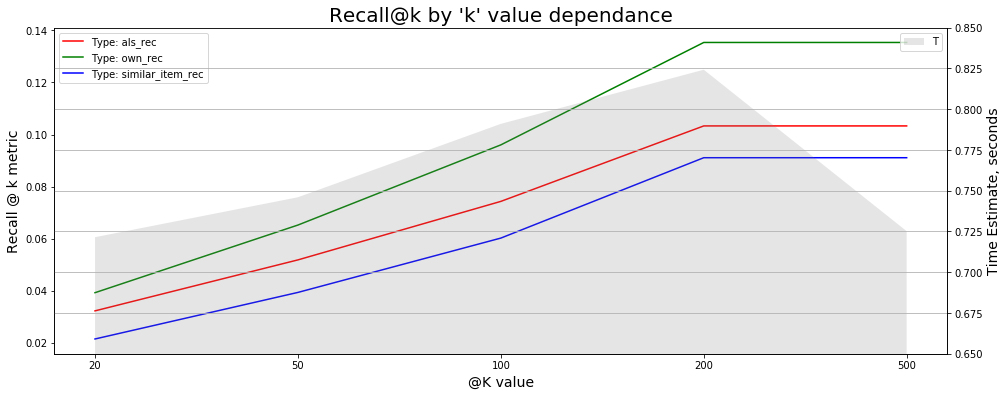

In [12]:
_, ax = plt.subplots(figsize=(16,6))


plt.gca().set_xticks(np.arange(len(k_list)))
plt.gca().set_xticklabels(k_list)


ax.plot(scores[...,0], 'r')
ax.plot(scores[...,1], 'g')
ax.plot(scores[...,2], 'b')

plt.xlabel('@K value', fontsize=14)
plt.ylabel('Recall @ k metric', fontsize=14)
ax.legend('Type: ' + cols)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.fill_between(np.arange(len(k_list)), t, facecolor='gray', interpolate=True, alpha=0.2)
plt.ylabel('Wall time @K, seconds', fontsize=14)
plt.gca().set_ylim(round(min(t),1)-0.05, round(max(t),1)+0.05)
# ax2.ylim(2,4)
ax2.legend('T', bbox_to_anchor=(1, 1))
plt.grid()
plt.title("Recall@k by 'k' value dependance", fontsize=20)


plt.show() # 200

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [14]:
# Train prep

users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]
users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=200))


In [15]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['drop'] = 1 


users_lvl_2.head()

,user_id,item_id,drop
0,2070,1105426,1
0,2070,1097350,1
0,2070,879194,1
0,2070,948640,1
0,2070,928263,1


In [16]:
users_lvl_2.shape[0]

430200

In [17]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('drop', axis=1, inplace=True)

In [18]:
"""Feats Preparation"""


### USER FEATS

# Income feature prepare
income_desc_lst = list(user_features.income_desc.unique())
income_desc_2_income = [int(re.search(r'\d{2,3}', l)[0]) for l in income_desc_lst]
income_dict = dict(zip(income_desc_lst, income_desc_2_income))

user_features['income, x1000 $'] = user_features['income_desc'].replace(income_dict)
user_features.drop('income_desc', axis=1, inplace=True)
print(f'Incomes dict: {income_dict}\n')

# Age feature prepare
age_desc_lst = list(user_features.age_desc.unique())
age_desc_2_age = [int(re.search(r'\d{2}', l)[0]) for l in age_desc_lst]
age_dict = dict(zip(age_desc_lst, age_desc_2_age))

user_features['age'] = user_features['age_desc'].replace(age_dict)
user_features.drop('age_desc', axis=1, inplace=True)
print(f'Ages dict: {age_dict}')


### ITEM FEATS


Incomes dict: {'35-49K': 35, '50-74K': 50, '25-34K': 25, '75-99K': 75, 'Under 15K': 15, '100-124K': 100, '15-24K': 15, '125-149K': 125, '150-174K': 150, '250K+': 250, '175-199K': 175, '200-249K': 200}

Ages dict: {'65+': 65, '45-54': 45, '25-34': 25, '35-44': 35, '19-24': 19, '55-64': 55}


In [162]:
item_features

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ
...,...,...,...,...,...,...,...
92348,18293142,6384,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,
92349,18293439,6393,DRUG GM,National,BOOKSTORE,CHILDRENS LOW END,
92350,18293696,6406,DRUG GM,National,BOOKSTORE,PAPERBACK BEST SELLER,
92351,18294080,6442,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,


In [19]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

In [20]:
targets_lvl_2['target'].mean()

0.06198326333060635

In [21]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [22]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'marital_status_code',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'income, x1000 $',
 'age']

In [25]:
%%time

lgb = LGBMClassifier(objective='binary', max_depth=5, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

# train_preds = lgb.predict_proba(X_train)

Wall time: 3.35 s


In [29]:
X_train.columns

Index(['user_id', 'item_id', 'manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
       'marital_status_code', 'homeowner_desc', 'hh_comp_desc',
       'household_size_desc', 'kid_category_desc', 'income, x1000 $', 'age'],
      dtype='object')

In [143]:
### Validation prep


result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']


val_users_lvl_2 = pd.DataFrame(data_val_lvl_2['user_id'].unique())
val_users_lvl_2.columns = ['user_id']
# Warm start
train_lvl_2_users = data_train_lvl_1['user_id'].unique()
val_users_lvl_2 = val_users_lvl_2[val_users_lvl_2['user_id'].isin(train_lvl_2_users)]
tmp_val_users = val_users_lvl_2.copy()
val_users_lvl_2['candidates'] = val_users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=200))



s2 = val_users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s2.name = 'item_id'
val_users_lvl_2 = val_users_lvl_2.drop('candidates', axis=1).join(s)
val_users_lvl_2['drop'] = 1 


val_targets_lvl_2 = data_val_lvl_2[['user_id', 'item_id']].copy()
val_targets_lvl_2['target'] = 1  # тут только покупки 

val_targets_lvl_2 = val_users_lvl_2.merge(val_targets_lvl_2, on=['user_id', 'item_id'], how='left')

val_targets_lvl_2.dropna(0, subset=['item_id'],inplace=True)
val_targets_lvl_2['item_id'] = val_targets_lvl_2['item_id'].astype('int64')


val_targets_lvl_2['target'].fillna(0, inplace= True)
val_targets_lvl_2.drop('drop', axis=1, inplace=True)


val_targets_lvl_2 = val_targets_lvl_2.merge(item_features, on='item_id', how='left')
val_targets_lvl_2 = val_targets_lvl_2.merge(user_features, on='user_id', how='left')

print(val_targets_lvl_2['target'].mean())

X_val = val_targets_lvl_2.drop('target', axis=1)

y_val = targets_lvl_2[['target']]

0.020066203324823804


In [145]:
X_val[cat_feats] = X_val[cat_feats].astype('category')

val_preds = lgb.predict_proba(X_val)[:, 1]
X_val['predict'] = val_preds
X_val.sort_values(['user_id', 'predict'], ascending=False, inplace=True)
result = X_val.groupby('user_id').head(200)

In [146]:
recs = result.groupby('user_id')['item_id']
recomendations = []
for user, preds in recs:
    recomendations.append({'user_id': user, 'recomendations': preds.tolist()})
    
recomendations = pd.DataFrame(recomendations)

In [149]:
# hot start correction

result_lvl_2 = result_lvl_2.merge(recomendations, how='left')
result_lvl_2.dropna(0, subset=['recomendations'], inplace=True)

In [159]:
result_lvl_2

,user_id,actual,recomendations
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1082185, 1082185, 1029743, 1070820, 1106523, ..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1082185, 845208, 1029743, 1029743, 1106523, 1..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1082185, 1029743, 1029743, 1106523, 1093413, ..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1082185, 1082185, 1082185, 1029743, 6602697, ..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1029743, 1029743, 1070820, 1075368, 1106523, ..."
...,...,...,...
2037,2496,[6534178],"[1082185, 1029743, 1106523, 1126899, 1070820, ..."
2038,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ...","[1082185, 1029743, 1029743, 1070820, 1070820, ..."
2039,2498,"[15716530, 834484, 901776, 914190, 958382, 972...","[962229, 15926886, 922561, 1056509, 5566309, 5..."
2040,2499,"[867188, 877580, 902396, 914190, 951590, 95813...","[1082185, 1029743, 1029743, 1070820, 1126899, ..."


In [155]:
# Precision compare

one_lvl_precision = result_lvl_1.apply(lambda row: precision_at_k(row['als_rec'], row['actual'], k=200), axis=1).mean()

two_lvl_precision = result_lvl_2.apply(
    lambda row: precision_at_k(row['recomendations'], row['actual'], k=200), axis=1).mean()

In [158]:
print(f'one_lvl_precision: {one_lvl_precision}')
print(f'two_lvl_precision: {two_lvl_precision}')

one_lvl_precision: 0.03351696885169697
two_lvl_precision: 0.014175662414131509


**Результат: точность снизилась, необходима доработка признаков**